IMPORT

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.metrics import BinaryAccuracy, AUC, Accuracy
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras import preprocessing
import matplotlib.pyplot as plt
#import tensorflow_addons as tfa
import random
import math

STANDARD VALUES

In [2]:
IMAGE_SIZE = 320
CHANNELS = 3
BATCH_SIZE = 16
EPOCHS = 10
IMAGES = 25000
TRAIN_VALIDATION_SPLIT = 0.8
FEATURES = "Path"
LABELS = ["Pneumonia", "Edema", "Fracture"]
METRICS = ["binary_accuracy", "accuracy", AUC(name = "auc", multi_label = True, from_logits = True)]

FUNCTIONS

In [3]:
def parse_image(features, label):
    image_string = tf.io.read_file(features)
    image = tf.image.decode_jpeg(image_string, channels = CHANNELS)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = image / 255.0
    
    return image, label

def create_dataset(dataframe):
    dataset = tf.data.Dataset.from_tensor_slices((dataframe[FEATURES].values, dataframe[LABELS].values))
    dataset = dataset.map(parse_image, num_parallel_calls = tf.data.experimental.AUTOTUNE)
    
    return dataset

def preprocess_dataset(dataset, is_training):
    dataset = dataset.cache().shuffle(10, reshuffle_each_iteration = False)
    
    if is_training == True:
        print(tf.data.experimental.cardinality(dataset))
        dataset_augmented = dataset.take(int(0.5*IMAGES*TRAIN_VALIDATION_SPLIT)).map(augment, num_parallel_calls = tf.data.experimental.AUTOTUNE)
        dataset = dataset.concatenate(dataset_augmented)
        print(tf.data.experimental.cardinality(dataset))

    dataset = dataset.batch(BATCH_SIZE).prefetch(buffer_size = tf.data.AUTOTUNE)
    
    return dataset

def augment(image, label):
    #image = tfa.image.rotate(image, random.uniform(-10,10)*math.pi/180)
    image = tf.image.central_crop(image, random.uniform(0.9, 1.0))
    image = tf.image.random_brightness(image, max_delta = 0.1)
    image = tf.image.random_contrast(image, lower = 0.9, upper = 1.1)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    
    return image, label

def plot_training(history):
    history_dict = history.history
    
    for h in history_dict:
        plt.plot(history.history[h])
        plt.title(h)
        plt.ylabel(h)
        plt.xlabel("epochs")
        plt.show()
        
def show_examples(dataset, number):
    for a,b in dataset.unbatch().shuffle(IMAGES).take(number):
        plt.imshow(a)
        print(b.numpy())

DATA FRAME

In [4]:
dataframe = pd.read_csv("Chexpert/train.csv")

for l in LABELS:
    dataframe[l][dataframe[l] < 0] = 0
    dataframe[l] = dataframe[l].fillna(0)

dataframe = dataframe[dataframe["Frontal/Lateral"] != "Lateral"][:IMAGES]

dataframe["Patient"] = dataframe.Path.str.split('/',3,True)[2].str.split("patient", 2, True)[1] 
dataframe["Patient"] = [i.lstrip("0") for i in dataframe["Patient"]]

dataframe["Study"] = dataframe.Path.str.split('/',4,True)[3].str.split("study", 2, True)[1]
    
dataframe.head()

/scratch/slurm_tmpdir/job_20528224/ipykernel_2056712/741237622.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe[l][dataframe[l] < 0] = 0


,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,...,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,Patient,Study
0,Chexpert/train/patient00001/study1/view1_front...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,0.0,NaN,NaN,0.0,1.0,1,1
1,Chexpert/train/patient00002/study2/view1_front...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,...,-1.0,0.0,-1.0,NaN,-1.0,NaN,1.0,NaN,2,2
2,Chexpert/train/patient00002/study1/view1_front...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,...,-1.0,0.0,NaN,NaN,NaN,NaN,1.0,NaN,2,1
4,Chexpert/train/patient00003/study1/view1_front...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,3,1
5,Chexpert/train/patient00004/study1/view1_front...,Female,20,Frontal,PA,1.0,0.0,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,4,1


In [5]:
dataframe.shape

(25000, 21)

CREATE DATASET

In [6]:
dataset = create_dataset(dataframe)

2022-03-14 22:36:27.241832: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-14 22:36:35.632068: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30980 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0
2022-03-14 22:36:35.667178: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30980 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:16:00.0, compute capability: 7.0


SPLIT DATASET

In [7]:
train_ds = dataset.take(int(TRAIN_VALIDATION_SPLIT*IMAGES))
valid_ds = dataset.skip(int(TRAIN_VALIDATION_SPLIT*IMAGES))

train_ds = preprocess_dataset(train_ds, True)
valid_ds = preprocess_dataset(valid_ds, False)

tf.Tensor(20000, shape=(), dtype=int64)
tf.Tensor(30000, shape=(), dtype=int64)


MODEL

In [8]:
base_model = DenseNet121(
    include_top = False, 
    weights = "imagenet", 
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS),
    pooling = None
)

base_model.trainable = False

inputs = tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = base_model(inputs, training = False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
initializer = tf.keras.initializers.GlorotUniform(seed = 42)

activation =  tf.keras.activations.sigmoid

outputs = tf.keras.layers.Dense(
    len(LABELS),
    kernel_initializer = initializer,
    activation = activation
)(x) 

model = tf.keras.Model(inputs, outputs)

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
    optimizer = "adam",
    metrics = METRICS
)

model.summary() 

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 320, 320, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 10, 10, 1024)      7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 3)                 3075      
                                                                 
Total params: 7,040,579
Trainable params: 3,075
Non-trainable params: 7,037,504
_________________________________________________________________


TRAINING

In [9]:
history = model.fit(train_ds, epochs = EPOCHS, validation_data = valid_ds)

Epoch 1/10


/opt/bwhpc/common/jupyter/tensorflow/2022-02-15/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
2022-03-14 22:36:54.461489: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8202


1875/1875 [==============================] - ETA: 0s - loss: 0.2656 - binary_accuracy: 0.8951 - accuracy: 0.2756 - auc: 0.6146

2022-03-14 22:38:53.571722: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1 of 10
2022-03-14 22:38:53.572000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


1875/1875 [==============================] - 145s 58ms/step - loss: 0.2656 - binary_accuracy: 0.8951 - accuracy: 0.2756 - auc: 0.6146 - val_loss: 0.2534 - val_binary_accuracy: 0.9053 - val_accuracy: 0.2500 - val_auc: 0.6423
Epoch 2/10
1875/1875 [==============================] - 86s 46ms/step - loss: 0.2562 - binary_accuracy: 0.8973 - accuracy: 0.2895 - auc: 0.6533 - val_loss: 0.2524 - val_binary_accuracy: 0.9063 - val_accuracy: 0.2518 - val_auc: 0.6568
Epoch 3/10
1875/1875 [==============================] - 86s 46ms/step - loss: 0.2530 - binary_accuracy: 0.8986 - accuracy: 0.2907 - auc: 0.6764 - val_loss: 0.2528 - val_binary_accuracy: 0.9068 - val_accuracy: 0.2528 - val_auc: 0.6582
Epoch 4/10
1875/1875 [==============================] - 86s 46ms/step - loss: 0.2509 - binary_accuracy: 0.8989 - accuracy: 0.2934 - auc: 0.6880 - val_loss: 0.2533 - val_binary_accuracy: 0.9069 - val_accuracy: 0.2560 - val_auc: 0.6612
Epoch 5/10
1875/1875 [==============================] - 85s 45ms/step - lo

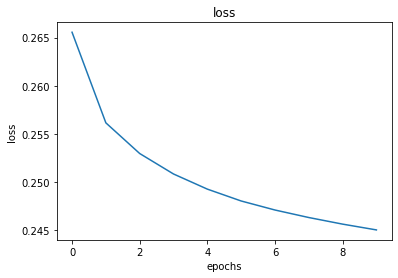

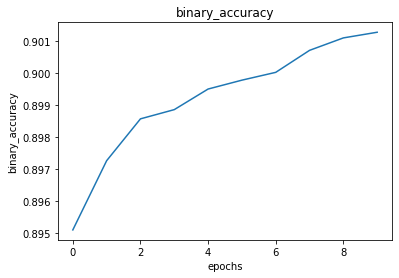

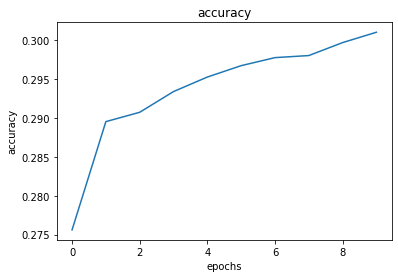

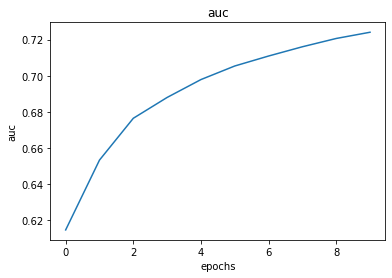

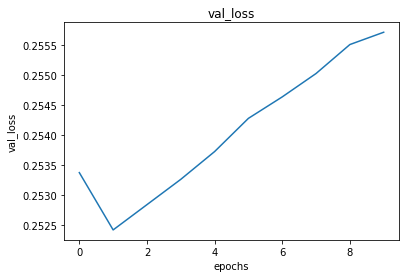

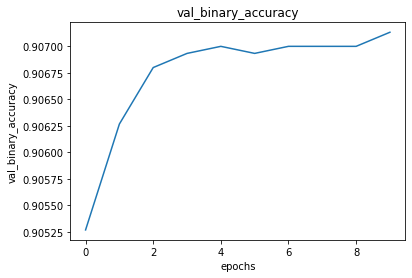

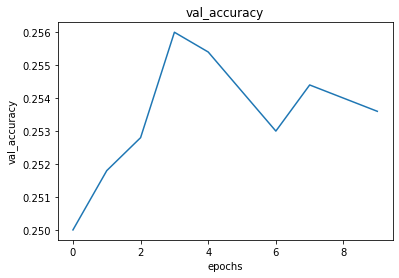

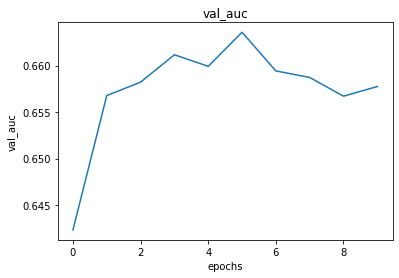

In [10]:
plot_training(history)

2022-03-14 22:52:08.101064: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 14581 of 25000
2022-03-14 22:52:15.612525: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


[0. 1. 0.]


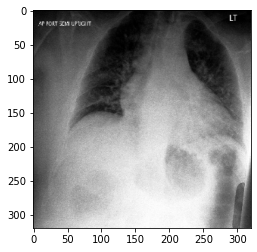

In [11]:
show_examples(train_ds, 1)